# Upload Data Set (Malaria detection) 

In [3]:
# install the dependencies
!pip install kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"solveyourerror","key":"ba2ddc59efb623337c4f7d945d370cbc"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# change the permission
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

100% 675M/675M [00:05<00:00, 169MB/s]
100% 675M/675M [00:05<00:00, 131MB/s]


In [8]:
from zipfile import ZipFile
file_name = "/content/cell-images-for-detecting-malaria.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


**install tensorflow-gpu**

In [9]:
!pip install tensorflow-gpu==2.0.0-rc0

     |████████████████████████████████| 380.5MB 40kB/s 
     |████████████████████████████████| 501kB 43.9MB/s 
     |████████████████████████████████| 4.3MB 37.4MB/s 


### **Import liberaries**

In [11]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.layers import  MaxPool2D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print(tf.__version__)

2.0.0-rc0


In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
import os
path = "/content/cell_images/cell_images"
path_data = os.listdir(path)
parasitized = os.listdir(path+'/'+path_data[0])#this modified code
uninfected = os.listdir(path+'/'+path_data[1])
parasitized.remove("Thumbs.db")
uninfected.remove("Thumbs.db")


In [16]:
#Now we have all image names in "parasitized" and "uninfected" lists. But images don't have same pixel rates and also all of them in "RGB" mode. We need to resize them to same pixel rates and turn their color mode to "L".
minh, minv = 100000,100000
for p in parasitized:
    pic = Image.open(path+'/'+path_data[0]+"/"+p)
    if pic.size[0] < minh:
        minh = pic.size[0]
    if pic.size[1] < minv:
        minv = pic.size[1]
for u in uninfected:
    pic = Image.open(path+'/'+path_data[1]+"/"+u)
    if pic.size[0] < minh:
        minh = pic.size[0]
    if pic.size[1] < minv:
        minv = pic.size[1]
print(minh)
print(minv)


46
40


In [0]:
# we find minimum pexel = 46*40
# Now resizeing it 
parasitized_list = []
for p in parasitized:
    image = Image.open(path+'/'+path_data[0]+"/"+p)
    image = image.resize((minh, minv))
    image = image.convert(mode="L")
    parasitized_list.append(image)
uninfected_list = []
for u in uninfected:
    image = Image.open(path+'/'+path_data[1]+"/"+u)
    image = image.resize((minh, minv))
    image = image.convert(mode="L")
    uninfected_list.append(image)


In [0]:
#create x(pixels) and y(class) axis for each images.
x = np.empty((len(uninfected)+len(parasitized), minh * minv))
index = 0
for pl in parasitized_list:
    x[index] = np.array(pl).reshape(minh * minv)
    index += 1
for ul in uninfected_list:
    x[index] = np.array(ul).reshape(minh * minv)
    index += 1    
p = np.ones(len(parasitized))#convert parasitized to 1 
u = np.zeros(len(uninfected))#convert uninfected to 0
y = np.concatenate((p,u),axis = 0)#.reshape(x.shape[0],1)#y is label


In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 42)
x_train = (x_train-np.min(x_train))/(np.max(x_train)-np.min(x_train))
x_test = (x_test-np.min(x_test))/(np.max(x_test)-np.min(x_test))

In [0]:
import tensorflow as tf
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)


In [0]:
# Define the normalized function
def min_max_normalized(data):
    col_max = np.max(data, axis=0)
    col_min = np.min(data, axis=0)
    return np.divide(data - col_min, col_max - col_min)

# Normalized processing, must be placed after the data set segmentation, 
# otherwise the test set will be affected by the training set
x_train = min_max_normalized(x_train)
x_test = min_max_normalized(x_test)


In [0]:
# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test/ 255.0

In [25]:
#check image shape
x_train[0].shape

(1840,)

In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:
img_width = 64
img_height = 64

In [0]:
datagen = ImageDataGenerator(rescale=1/255.0, validation_split=0.2)

In [29]:
train_data_generator = datagen.flow_from_directory(directory='/content/cell_images/cell_images',
                                                   target_size = (img_width, img_height),
                                                   class_mode = 'binary',
                                                   batch_size = 16,
                                                   subset = 'training'
)

Found 22048 images belonging to 2 classes.


In [30]:
validation_data_generator = datagen.flow_from_directory(directory='/content/cell_images/cell_images',
                                                   target_size = (img_width, img_height),
                                                   class_mode = 'binary',
                                                   batch_size = 16,
                                                   subset = 'validation'
)

Found 5510 images belonging to 2 classes.


In [31]:
train_data_generator.labels

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

# **CNN Model Building**

In [0]:
model = Sequential()

model.add(Conv2D(16, (3,3), input_shape = (img_width, img_height, 3), activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0

In [0]:
# data optimization is adam
model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

In [35]:
# train
history = model.fit_generator(generator=train_data_generator,
                              steps_per_epoch = len(train_data_generator),
                              epochs = 5,
                              validation_data = validation_data_generator,
                              validation_steps = len(validation_data_generator))

Epoch 1/5
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
1378/1378 [==============================] - 151s 109ms/step - loss: 0.4410 - accuracy: 0.7916 - val_loss: 0.2126 - val_accuracy: 0.9299
Epoch 2/5
1378/1378 [==============================] - 150s 109ms/step - loss: 0.2223 - accuracy: 0.9187 - val_loss: 0.1802 - val_accuracy: 0.9372
Epoch 3/5
1378/1378 [==============================] - 151s 110ms/step - loss: 0.1976 - accuracy: 0.9376 - val_loss: 0.1731 - val_accuracy: 0.9434
Epoch 4/5
1378/1378 [==============================] - 153s 111ms/step - loss: 0.1773 - accuracy: 0.9450 - val_loss: 0.1660 - val_accuracy: 0.9432
Epoch 5/5
1378/1378 [==============================] - 151s 110ms/step - loss: 0.1647 - accuracy: 0.9488 - val_loss: 0.1745 - val_accuracy: 0.9367


In [36]:
history.history

{'accuracy': [0.7916364, 0.9187228, 0.9375907, 0.94498366, 0.9488389],
 'loss': [0.44102403676172475,
  0.2223211324020831,
  0.19756779229641502,
  0.17732509912406627,
  0.16469104885676517],
 'val_accuracy': [0.9299455, 0.9372051, 0.9433757, 0.9431942, 0.9366606],
 'val_loss': [0.2126327488085498,
  0.1801677700780008,
  0.17306402791021527,
  0.16596224463504294,
  0.17445868410817955]}

In [0]:
def plot_learningCurve(history, epoch):
  # Plot training & validation accuracy values
  epoch_range = range(1, epoch+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()  

In [0]:
!kill 2062
%tensorboard --logdir logs

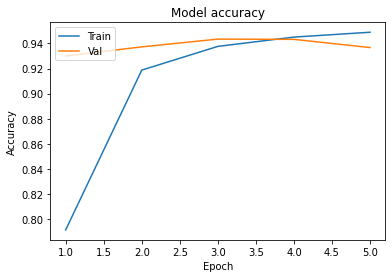

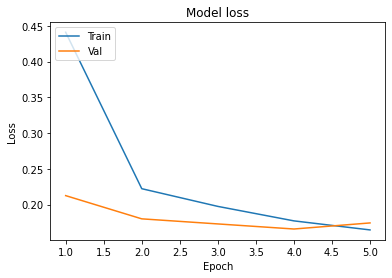

In [53]:
plot_learningCurve(history, 5)

# **Confusion Matrix**

In [0]:
preds = model.predict(eval_x, batch_size=16)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(eval_y, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

print(np.unique(orig_test_labels))
print(np.unique(preds))

(5512,)

(5512,)

[0 1]

[0]

In [0]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(orig_test_labels , preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Infected'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Infected'], fontsize=16)
plt.show()

![alt text](https://www.kaggleusercontent.com/kf/14947753/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..6N1ZCzdVT2tgBhMkhifOWA.j_oxnboY7LhjIaTSVn0gRHpsb2RITbEpHMmmAQY5Cu085N1QdYKUtO3kJH62RJakJtnWfqucx3Ad_Tn7k1r_3cvs_tmX_pj91A9HmfnvL5h0wcP5Ex-9dgSkuG8prEldb_15UFtDvQjOiy_BXrQv9j5ZJvHIS-mRA9HFHS_rO130vgfu9b7o9R-3kkYWSyB5YsEhq7QKtY_GlfqxTfUt17UNds2ldS-lCVARd2k4E8fVtoM2ThnDtRgKu0l0M6cpNNpZhs4OMnMP3tcq-2phNA_18gq-ZF7OMhqmPH6yC7QD5EK046yyoouqS_UZ3hZlC36M8MYLNwF-eD3iRtXlJM5hchTQWX3uLOEOY6DpOq5xlIOx3SBUgKbLTPDW6qF57ftUv8VPsTCv34geg-mcgxCqF9bDOpAeGSzjPBjXDx2x6UG-zlhq3fUTZnKjPlgYSea_gkn71feZHkSFdA6IcX1Ww3ftaUThTUycZr2ZC8HuGLSOUjAz5jShLDWHrJgAVpqMvH2OCJ2jegEf6m3_5KP2333UR1MZMoKNynqVb0_NdpTIdDTc1bLFnC0SoU9ff0sbyhDo7eHs0jEkaJZ2cBRyTlx_TGhTplv3YScRLLBSuVw3mRi-pwuggtCFEb6TgUah5IeP4fJkqieDeIWv0YESanodYNyu92a4ADHj1-puI5E-y_Y8lvQa-ptqrrF_.peE4S3F70LP42rk4-KtWxw/__results___files/__results___32_1.png)